In [1]:
### BAU - Tez Çalışması 2023 / Hakan Damar ###
## Askeri Savaş Uçağı Tespit Örneği ##

# Clone Yolo-v7 repository 
!git clone https://github.com/WongKinYiu/yolov7.git

%cd yolov7

!python --version
!nvcc --version

C:\Users\Hakan\Documents\__TEZ-2023-Examples\conda-environment\Military Aircraft Detection\yolov7
Python 3.8.16
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_22:08:44_Pacific_Standard_Time_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


In [5]:
# Eğitim ve Test veri setlerini ayırıyoruz
import os
import shutil
import torch

dataset_path = r'../dataset'
data_path = os.listdir(dataset_path)
data_count = 0

for path in data_path:
    if os.path.isfile(os.path.join(dataset_path, path)):
        data_count += 1

train_data_count = int(data_count * 0.80)
val_data_count = int(data_count * 0.20)

print("Eğitim Veri Seti Sayısı: " + str(train_data_count))
print("Değerlendirme Veri Seti Sayısı: "   + str(val_data_count))
print("Toplam Veri Seti Sayısı: " + str(data_count))

if torch.cuda.is_available() == True:
    print("GPUs Ready!")
else:
    print("GPUs not available!")
    
print(torch.rand(2,3).cuda())

Eğitim Veri Seti Sayısı: 17416
Değerlendirme Veri Seti Sayısı: 4354
Toplam Veri Seti Sayısı: 21770
GPUs Ready!
tensor([[0.6432, 0.4207, 0.1369],
        [0.5423, 0.8905, 0.1639]], device='cuda:0')


In [4]:
# Veri Seti Kontrolü
train_dataset = data_path[:train_data_count]
val_dataset = data_path[train_data_count:]

if int(train_data_count) == len(train_dataset) and int(val_data_count) == len(val_dataset):
    print("Eğitim ve doğrulama veri seti eşit.")
else:
    print("HATA: Eğitim ve doğrulama veri seti eşit değil!")

HATA: Eğitim ve doğrulama veri seti eşit değil!


In [5]:
# Eğitim veri setini kopyalama işlemini (Sadece 1 kez çalıştırılması gerekmektedir!)

# <file>.jpg ve <annotation>.csv aynı isim farklı dosya uzantısına sahip olduğundan mutlaka test, eğitim veri seti bölünürken 
# son verinin etiket dosyasınında alınmış olmasına dikkat edilmesi gerekmektedir.

dataset_full_path = r'../dataset/'
train_path = r'./data/train/csv_labels/'

# Daha önce çalıştırılıp çalıştırılmadığını kontrol ediyoruz.
train_path_list = os.listdir(train_path)
for train_file in train_path_list:
    if os.path.isfile(os.path.join(train_path, train_file)):
        print("Daha önce eğitim veri seti kopyalandığı için bu komut tekrar çalıştırılamaz!")
        break
    
count=train_data_count
for i in train_dataset:
    # images ve csv_labels kopyalanırken buradaki kontrolü güncellemeyi unutma! CSV copy == / JPG copy !=
    if i.split(".")[-1] != "csv":
        continue
        
    if count >= 1:
        dataset_file_path = dataset_full_path + i
        shutil.copy2(dataset_file_path, train_path)
    else:
        break
    count -= 1

In [9]:
# Test veri setini kopyalama işlemi (Sadece 1 kez çalıştırılması gerekmektedir!)

# <file>.jpg ve <annotation>.csv aynı isim farklı dosya uzantısına sahip olduğundan mutlaka test, eğitim veri seti bölünürken 
# son verinin etiket dosyasınında alınmış olmasına dikkat edilmesi gerekmektedir.

dataset_full_path = r'../dataset/'
val_path = r'./data/validation/csv_labels/'

# Daha önce çalıştırılıp çalıştırılmadığını kontrol ediyoruz.
val_path_list = os.listdir(val_path)
for val_file in val_path_list:
    if os.path.isfile(os.path.join(val_path, val_file)):
        print("Daha önce doğrulama veri seti kopyalandığı için bu komut tekrar çalıştırılamaz!")
        break
    
count=val_data_count
for i in val_dataset:
    # images ve csv_labels kopyalanırken buradaki kontrolü güncellemeyi unutma! CSV copy == / JPG copy !=
    if i.split(".")[-1] != "csv":
        continue
    if count >= 1:
        dataset_file_path = dataset_full_path + i
        shutil.copy2(dataset_file_path, val_path)
    else:
        break
    count -= 1

In [15]:
# Yolo v7 modelinin ağırlıklarını indiriyoruz (transfer learning için yolov7.pt yerine yolov7_training.pt'yi kullanıyoruz)
!curl -o yolov7_training.pt -k https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7_training.pt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0


In [3]:
# YOLO V7 modelini yeniden eğitmeden önce gerekli bağımlılıkları yüklüyoruz
!pip install -r requirements.txt

In [14]:
# Veri setini YOLO v7 annotation formatı ile uyumlu hale getirmek için mevcut CSV verilerini işliyoruz
from csv import reader

# Validation ve Training için ayrı ayrı çalıştırılması gerekmektedir. (train/validation)
data_path = r'./data/validation/csv_labels/'
data_list = os.listdir(dataset_path)
ann_info_list = []

# Yolo v7 uyumlu şekilde dönüştürme işlemini yapıyoruz.
def annotation_extractor_from_csv(csv_line):
    ann_info_dict = {}
    ann_info_dict['bboxes'] = []
    
    bbox = {}           
    bbox["class"] = csv_line[3]
    bbox["xmin"]  = csv_line[4]
    bbox["ymin"]  = csv_line[5]
    bbox["xmax"]  = csv_line[6]
    bbox["ymax"]  = csv_line[7]
    
    ann_info_dict['filename'] = csv_line[0]
    ann_info_dict['image_size'] = (csv_line[1], csv_line[2])    
    ann_info_dict['bboxes'].append(bbox)
    
    return ann_info_dict

for path in data_list:
    if os.path.isfile(os.path.join(data_path, path)):
        full_path = data_path + path
        if(path[-3:] != "csv"):
            continue
        
        with open(full_path, 'r', encoding="utf8") as read_csv:
            file_reader = reader(read_csv)
            # Header bilgisini atlıyoruz.
            header = next(read_csv)
            
            if header != None:
                for line in file_reader:
                    extracted_ann = annotation_extractor_from_csv(line)
                    ann_info_list.append(extracted_ann)
                    
        ##> Test Code / Sadece 1 kere çalıştırarak kodu test ediyoruz.
        #break
        
if(len(ann_info_list) > 1):
    print("Toplam işlenen etiket sayısı: " + str(len(ann_info_list)))
    print("Veri seti ön işleme süreci tamamlandı")
else:
    print("Veri seti ön işleme hatası!")

##> Test code  
#print(ann_info_list)

##> Test output: {'filename': 'cd3f6d14673dde618c3052a6701e77e4', 'image_size': ('2658', '1896'), 'bboxes': {'class': 'US2', 'xmin': '97', 'ymin': '429', 'xmax': '2560', 'ymax': '1305'}}

Toplam işlenen etiket sayısı: 3438
Veri seti ön işleme süreci tamamlandı


In [6]:
# Modelimizde kullanacağımız sınıf adları ile ID'lerin bir haritasını oluşturuyoruz.
class_name_and_id_map = { 'A10': 0, 'A400M': 1, 'AG600': 2, 'AV8B': 3, 'B1': 4, 'B2': 5, 'B52': 6, 'Be200': 7, 'C130': 8, 'C17': 9, 'C2': 10, 
                          'C5': 11, 'E2': 12, 'E7': 13, 'EF2000': 14, 'F117': 15, 'F14': 16, 'F15': 17, 'F16': 18, 'F18': 19, 'F22': 20,
                          'F35': 21, 'F4': 22, 'J20': 23, 'JAS39': 24, 'MQ9': 25, 'Mig31': 26, 'Mirage2000': 27, 'P3': 28, 'RQ4': 29, 'Rafale': 30,
                          'SR71': 31, 'Su34': 32, 'Su57': 33, 'Tornado': 34, 'Tu160': 35, 'Tu95': 36, 'U2': 37, "US2": 38, 'V22': 39, 'Vulcan': 40,
                          'XB70': 41, 'YF23': 42 }

# Mevcut annotation formatını Yolo V7'ye uyumlu hale çeviriyoruz
def annotation_converter_for_yoolov7(ann_list, target):
    counter = 0
    
    for ann_dict in ann_list:
        file_buffer = []
        for b in ann_dict["bboxes"]:
            try:
                class_id = class_name_and_id_map[b["class"]]
            except KeyError:
                print("Geçersiz sınıf! Verilen sınıf, modelin desteklediği sınıflardan biri olmalıdır: ", class_name_and_id_map.keys())
        
            # Bounding box kordinatlarını YOLO v7'ye göre dönüştürüyoruz.
            ## b[1] => b["xmin"] / b[3] => b["xmax"]
            b_center_x = (int(b["xmin"]) + int(b["xmax"])) / 2 
            ## b[2] => b["ymin"] / b[4] => b["ymax"]
            b_center_y = (int(b["ymin"]) + int(b["ymax"])) / 2
            ## b[3] => b["xmax"] / b[4] => b["ymax"]
            b_width    = (int(b["xmax"]) - int(b["xmin"]))
            ## b[4] => b["ymax"] / b[2] => b["ymin"]
            b_height   = (int(b["ymax"]) - int(b["ymin"]))

            # Bounding box'taki kordinatları resmin boyutlarına göre normalize ediyoruz.
            image_w, image_h = ann_dict["image_size"]
            image_w = int(image_w)
            image_h = int(image_h)
            b_center_x /= image_w 
            b_center_y /= image_h 
            b_width    /= image_w 
            b_height   /= image_h

            # Yeni bounding box değerlerini dosyaya yazıyoruz
            file_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
            
        save_file_name = os.path.join("data/" + target + "/labels/", ann_dict["filename"] + ".txt")
        print("\n".join(file_buffer), file = open(save_file_name, "a+", encoding="utf8"))
        counter += 1
    
    if(len(file_buffer) >= 1):
        print(str(counter) + " adet etiket başarıyla oluşturuldu")
    else:
        print("Etiket dosyaları oluşturulamadı!")

In [15]:
## Input parameters: <dic>, <str> -> validation || train (Bu komutu çalıştırmadan önce annotation_extractor_from_csv methodundaki path'i update etmeyi unutma)
annotation_converter_for_yoolov7(ann_info_list, "validation")

3438 adet etiket başarıyla oluşturuldu


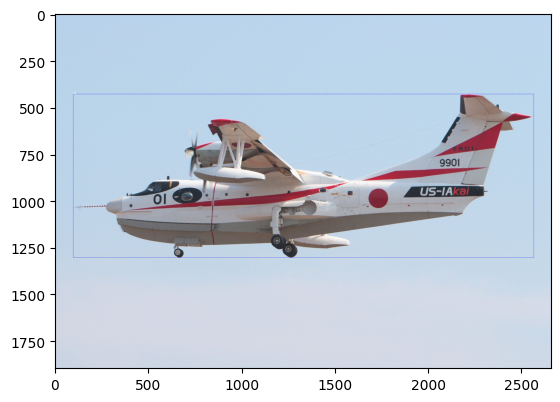

In [7]:
# YOLO v7 için oluşturduğumuz yeni etiketlerimizi test ediyoruz
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

def plot_bbox(img, anno_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    plotted_image = ImageDraw.Draw(image)
    
    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 

    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        head, sep, tail = str(obj_cls).partition('.')
        obj_cls = list(class_name_and_id_map)[int(head)]
        
        plotted_image.rectangle(((x0,y0), (x1,y1)), outline=(0,0,255,255))
        plotted_image.text((x0, y0 - 10), obj_cls)
        
    plt.imshow(np.array(image))
    plt.show()

# Test resim ve etiketi
test_annotation_file = r'data/validation/labels/cd3f6d14673dde618c3052a6701e77e4.txt'
test_image = r'data/validation/images/cd3f6d14673dde618c3052a6701e77e4.jpg'

# Test etiket verisini işliyoruz.
with open(test_annotation_file, "r", encoding="utf8") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]
    
# Test resmini açıyoruz.
image = Image.open(test_image)
plot_bbox(image, annotation_list)

In [ ]:
# Modelimizi askeri uçakları tanıyacak şekilde eğitiyoruz
os.environ["PL_TORCH_DISTRIBUTED_BACKEND"] = "gloo"

!python train.py --workers 8 --device 0,1 --sync-bn --batch-size 32 --epochs 100 --img 640 640 --cfg cfg/training/yolov7.yaml --hyp data/hyp.scratch.custom.yaml --data data/bau-custom.yaml --weights yolov7_training.pt --name yolov7_bau

In [4]:
 # Yeni modelimiz ile veri setinde olmayan bir fotoğraf kullanarak test tahminlemesi yapıyoruz.
!python detect.py --weights HD_BAU-model.pt --conf 0.5 --img-size 640 --source test_pred_img.jpg --view-img --no-trace --save-txt

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.5, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', no_trace=True, nosave=False, project='runs/detect', save_conf=False, save_txt=True, source='test_pred_img.jpg', update=False, view_img=True, weights=['HD_BAU-model.pt'])
Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
1 Rafale, Done. (17.0ms) Inference, (4.0ms) NMS
 The image with the result is saved in: runs\detect\exp6\test_pred_img.jpg
Done. (0.183s)


YOLOR  2023-4-14 torch 1.13.1+cu117 CUDA:0 (NVIDIA TITAN RTX, 24575.5625MB)
                                     CUDA:1 (NVIDIA TITAN RTX, 24575.5625MB)

C:\Users\Hakan\anaconda3\envs\bau-custom-model\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 314 layers, 36708320 parameters, 6194944 gradients, 103.9 GFLOPS


In [8]:
# Yeni modelimizi örnek bir YouTube videosu üzerinde test tahminlemesi yaptırıyoruz
!python detect.py --weights HD_BAU-model.pt --conf 0.7 --img-size 640 --source test_pred.mp4 --no-trace

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.7, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', no_trace=True, nosave=False, project='runs/detect', save_conf=False, save_txt=False, source='test_pred.mp4', update=False, view_img=False, weights=['HD_BAU-model.pt'])
Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
video 1/1 (1/3941) C:\Users\Hakan\Documents\__TEZ-2023-Examples\conda-environment\Military Aircraft Detection\yolov7\test_pred.mp4: Done. (18.0ms) Inference, (1.0ms) NMS
video 1/1 (2/3941) C:\Users\Hakan\Documents\__TEZ-2023-Examples\conda-environment\Military Aircraft Detection\yolov7\test_pred.mp4: Done. (18.0ms) Inference, (1.0ms) NMS
video 1/1 (3/3941) C:\Users\Hakan\Documents\__TEZ-2023-Examples\conda-environment\Military Aircraft Detection\yolov7\test_pred.mp4: Done. (17.0ms) Inference, (1.0ms) NMS
video 1/1 (4/3941) C:\Users\Hakan\Documents\__TEZ-2023-Examples\conda

YOLOR  2023-4-14 torch 1.13.1+cu117 CUDA:0 (NVIDIA TITAN RTX, 24575.5625MB)
                                     CUDA:1 (NVIDIA TITAN RTX, 24575.5625MB)

C:\Users\Hakan\anaconda3\envs\bau-custom-model\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 314 layers, 36708320 parameters, 6194944 gradients, 103.9 GFLOPS
